# シンプルなFC層を用いたモデル

### 方針

・条件付き確率（遷移確率）と尤度の和から次の尤度を求める

### データの生成

・データの用意

In [34]:
import numpy as np

# 生徒数と問題数を設定
num_students = 100  # 生徒の数
num_questions = 5   # 問題の数

# ランダムに正解(1)または不正解(0)を生成
np.random.seed(42)  # 再現性のためのシード値設定
test_results = np.random.randint(0, 2, size=(num_students, num_questions)).tolist()

# 追加するデータセット
additional_data = [
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1]
]

# 各データを3つずつ追加
for data in additional_data:
    test_results.extend([data] * 5)  # 同じデータを5回追加

# 結果を表示
for i, result in enumerate(test_results):
    print(f"Student {i+1}: {result}")


Student 1: [0, 1, 0, 0, 0]
Student 2: [1, 0, 0, 0, 1]
Student 3: [0, 0, 0, 0, 1]
Student 4: [0, 1, 1, 1, 0]
Student 5: [1, 0, 1, 1, 1]
Student 6: [1, 1, 1, 1, 1]
Student 7: [0, 0, 1, 1, 1]
Student 8: [0, 1, 0, 0, 0]
Student 9: [0, 0, 1, 1, 1]
Student 10: [1, 1, 0, 1, 1]
Student 11: [0, 1, 0, 1, 0]
Student 12: [1, 1, 0, 0, 0]
Student 13: [0, 0, 0, 0, 0]
Student 14: [1, 1, 0, 1, 1]
Student 15: [1, 1, 0, 1, 0]
Student 16: [1, 1, 1, 0, 1]
Student 17: [0, 1, 0, 1, 0]
Student 18: [0, 1, 0, 1, 1]
Student 19: [1, 1, 1, 1, 1]
Student 20: [1, 1, 1, 1, 0]
Student 21: [0, 1, 1, 1, 1]
Student 22: [1, 1, 1, 1, 0]
Student 23: [1, 0, 1, 1, 0]
Student 24: [1, 0, 1, 1, 0]
Student 25: [1, 0, 1, 0, 0]
Student 26: [1, 1, 0, 1, 1]
Student 27: [1, 0, 0, 0, 0]
Student 28: [0, 0, 0, 0, 0]
Student 29: [1, 0, 1, 1, 1]
Student 30: [0, 0, 0, 0, 1]
Student 31: [0, 0, 0, 0, 0]
Student 32: [1, 0, 1, 0, 1]
Student 33: [0, 0, 1, 1, 1]
Student 34: [0, 1, 0, 0, 1]
Student 35: [1, 0, 0, 1, 1]
Student 36: [1, 0, 0, 0, 0]
S

In [35]:
import itertools
from collections import defaultdict

# 問題数5問に対する全ての可能な状態 (2^5 = 32状態)
states = list(itertools.product([0, 1], repeat=num_questions))
print(f"number of States: {len(states)}")

# 各状態（ノード）に生徒を配置する (状態ごとの生徒数をカウント)
state_counts = defaultdict(int)

# 生徒ごとのテスト結果を元に状態に生徒をカウント
for result in test_results:
    state_tuple = tuple(result)
    state_counts[state_tuple] += 1

# 各状態の生徒数を表示
for state, count in state_counts.items():
    print(f"State {state}: {count} students")

number of States: 32
State (0, 1, 0, 0, 0): 3 students
State (1, 0, 0, 0, 1): 2 students
State (0, 0, 0, 0, 1): 3 students
State (0, 1, 1, 1, 0): 2 students
State (1, 0, 1, 1, 1): 3 students
State (1, 1, 1, 1, 1): 9 students
State (0, 0, 1, 1, 1): 5 students
State (1, 1, 0, 1, 1): 3 students
State (0, 1, 0, 1, 0): 5 students
State (1, 1, 0, 0, 0): 6 students
State (0, 0, 0, 0, 0): 5 students
State (1, 1, 0, 1, 0): 3 students
State (1, 1, 1, 0, 1): 4 students
State (0, 1, 0, 1, 1): 3 students
State (1, 1, 1, 1, 0): 11 students
State (0, 1, 1, 1, 1): 2 students
State (1, 0, 1, 1, 0): 2 students
State (1, 0, 1, 0, 0): 6 students
State (1, 0, 0, 0, 0): 9 students
State (1, 0, 1, 0, 1): 4 students
State (0, 1, 0, 0, 1): 4 students
State (1, 0, 0, 1, 1): 4 students
State (0, 0, 1, 0, 0): 1 students
State (1, 1, 1, 0, 0): 9 students
State (0, 0, 1, 1, 0): 3 students
State (0, 0, 0, 1, 1): 2 students
State (1, 1, 0, 0, 1): 2 students
State (0, 0, 1, 0, 1): 4 students
State (0, 1, 1, 0, 0): 4 s

・遷移確率の計算

In [36]:
# 遷移確率を計算するための準備
transition_probabilities = defaultdict(dict)

# 各状態について、次の状態に遷移する確率を計算
for current_state, count in state_counts.items():
    # 次に解ける可能性のある未解決の問題を見つける
    for i in range(num_questions):
        if current_state[i] == 0:  # まだ解けていない問題
            # その問題が解けた状態を生成（遷移後の状態）
            next_state = list(current_state)
            next_state[i] = 1
            next_state = tuple(next_state)
            
            # 現在の状態から次の状態に遷移する確率を仮定 (生徒が1問解ける)
            transition_probabilities[current_state][next_state] = 1 / (num_questions - sum(current_state))

# 遷移確率の表示
for current_state, next_states in transition_probabilities.items():
    print(f"From state {current_state}:")
    for next_state, prob in next_states.items():
        print(f"  To {next_state} with probability {prob:.2f}")

From state (0, 1, 0, 0, 0):
  To (1, 1, 0, 0, 0) with probability 0.25
  To (0, 1, 1, 0, 0) with probability 0.25
  To (0, 1, 0, 1, 0) with probability 0.25
  To (0, 1, 0, 0, 1) with probability 0.25
From state (1, 0, 0, 0, 1):
  To (1, 1, 0, 0, 1) with probability 0.33
  To (1, 0, 1, 0, 1) with probability 0.33
  To (1, 0, 0, 1, 1) with probability 0.33
From state (0, 0, 0, 0, 1):
  To (1, 0, 0, 0, 1) with probability 0.25
  To (0, 1, 0, 0, 1) with probability 0.25
  To (0, 0, 1, 0, 1) with probability 0.25
  To (0, 0, 0, 1, 1) with probability 0.25
From state (0, 1, 1, 1, 0):
  To (1, 1, 1, 1, 0) with probability 0.50
  To (0, 1, 1, 1, 1) with probability 0.50
From state (1, 0, 1, 1, 1):
  To (1, 1, 1, 1, 1) with probability 1.00
From state (0, 0, 1, 1, 1):
  To (1, 0, 1, 1, 1) with probability 0.50
  To (0, 1, 1, 1, 1) with probability 0.50
From state (1, 1, 0, 1, 1):
  To (1, 1, 1, 1, 1) with probability 1.00
From state (0, 1, 0, 1, 0):
  To (1, 1, 0, 1, 0) with probability 0.33
  

### 尤度（ベイズ）

In [37]:
# ベイズの定理に基づく遷移確率の計算
bayesian_transition_probabilities = defaultdict(dict)

for current_state, next_states in transition_probabilities.items():
    P_S = state_counts[current_state] / sum(state_counts.values())  # 状態Sにいる確率
    for next_state, P_S_given_S_prime in next_states.items():
        # ベイズの定理に基づく遷移確率 P(S'|S)
        bayesian_transition_probabilities[current_state][next_state] = P_S_given_S_prime * P_S

# ベイズ遷移確率を表示
for current_state, next_states in bayesian_transition_probabilities.items():
    print(f"From state {current_state}:")
    for next_state, prob in next_states.items():
        print(f"  To {next_state} with bayesian probability {prob:.2f}")


From state (0, 1, 0, 0, 0):
  To (1, 1, 0, 0, 0) with bayesian probability 0.01
  To (0, 1, 1, 0, 0) with bayesian probability 0.01
  To (0, 1, 0, 1, 0) with bayesian probability 0.01
  To (0, 1, 0, 0, 1) with bayesian probability 0.01
From state (1, 0, 0, 0, 1):
  To (1, 1, 0, 0, 1) with bayesian probability 0.01
  To (1, 0, 1, 0, 1) with bayesian probability 0.01
  To (1, 0, 0, 1, 1) with bayesian probability 0.01
From state (0, 0, 0, 0, 1):
  To (1, 0, 0, 0, 1) with bayesian probability 0.01
  To (0, 1, 0, 0, 1) with bayesian probability 0.01
  To (0, 0, 1, 0, 1) with bayesian probability 0.01
  To (0, 0, 0, 1, 1) with bayesian probability 0.01
From state (0, 1, 1, 1, 0):
  To (1, 1, 1, 1, 0) with bayesian probability 0.01
  To (0, 1, 1, 1, 1) with bayesian probability 0.01
From state (1, 0, 1, 1, 1):
  To (1, 1, 1, 1, 1) with bayesian probability 0.02
From state (0, 0, 1, 1, 1):
  To (1, 0, 1, 1, 1) with bayesian probability 0.02
  To (0, 1, 1, 1, 1) with bayesian probability 0.02


・図示

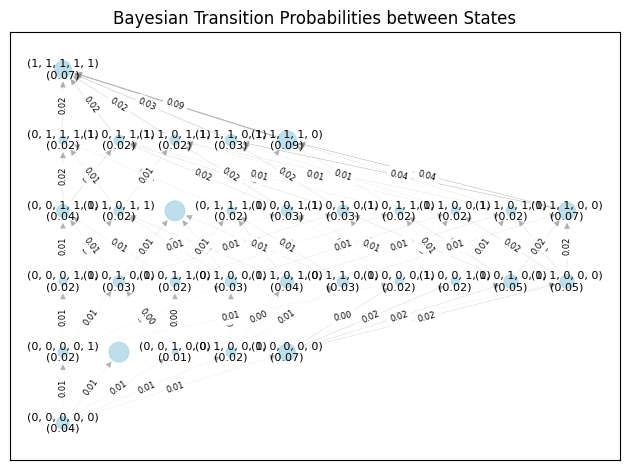

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# 問題数
num_questions = 5

# 全ての状態(2^5 = 32通り)を生成
states = list(itertools.product([0, 1], repeat=num_questions))

# グラフの作成
G = nx.DiGraph()

# ノードを追加（状態をノードとして）
state_likelihoods = {}
for state, count in state_counts.items():
    likelihood = count / sum(state_counts.values())  # 尤度の計算
    state_likelihoods[state] = likelihood
    G.add_node(state, label=f"{state}\n({likelihood:.2f})")  # ノードの追加

# エッジを追加（遷移確率をエッジとして）
for current_state, next_states in bayesian_transition_probabilities.items():
    for next_state, prob in next_states.items():
        G.add_edge(current_state, next_state, weight=prob)

# ノードの階層に基づくレイアウトを定義
def generate_hierarchy_pos(states):
    layers = defaultdict(list)  # 各ビット数ごとに層を分ける
    for state in states:
        bit_count = sum(state)  # 1の数に応じて層を決定
        layers[bit_count].append(state)

    pos = {}
    y_step = 1.0  # 各層ごとの縦の間隔 (正の値にして上下を逆に)
    x_step = 1 / max(len(layer) for layer in layers.values())  # 横の間隔は最大層のノード数で決める
    for bit_count, layer in sorted(layers.items()):
        y = bit_count * y_step
        x_positions = [i * x_step for i in range(len(layer))]
        for x, state in zip(x_positions, layer):
            pos[state] = (x, y)
    return pos

# ノードの位置を階層構造に基づいて設定
pos = generate_hierarchy_pos(states)

# ノードのサイズを尤度に基づいて設定
sizes = [state_likelihoods.get(state, 0.1) * 2000 for state in G.nodes]  # ノードサイズはリストとして渡す

# ノードの描画
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightblue', alpha=0.8)

# エッジの描画（遷移確率に基づいてエッジの太さを調整）
edges = G.edges(data=True)
weights = [d['weight'] * 10 for (u, v, d) in edges]  # 遷移確率に基づいてエッジの太さを設定
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.6)

# ノードのラベルを描画（フォントサイズを調整）
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center', horizontalalignment='center')

# エッジのラベル（遷移確率）を表示（フォントサイズを小さくし、読みやすく配置）
edge_labels = {(u, v): f"{d['weight']:.2f}" for (u, v, d) in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# グラフを表示
plt.title("Bayesian Transition Probabilities between States", fontsize=12)
plt.tight_layout()
plt.show()


### 学習

### テスト